In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc 

In [4]:
# from pre_processing import *
# data=pd.read_csv("GSE92332_AtlasFullLength_TPM.txt",sep="\t").T
# adata = preprocess(data)

In [ ]:
# adata.write("preprocessedAdata.h5ad")

In [5]:
adata = sc.read("preprocessedAdata.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 1415 × 2000
    obs: 'celltype', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'scrublet'
    obsm: 'X_pca'
    varm: 'PCs'

In [7]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.tsne(adata)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from sklearn.cluster import SpectralClustering
K = 11 # number of celltypes 
specCluster = SpectralClustering(n_clusters=K)

adata.obs['spectral_pca'] = specCluster.fit_predict(adata.obsm['X_pca'][:, :3])  # Use the first 5 principal components
adata.obs['spectral_pca'] = adata.obs['spectral_pca'].astype('category')

adata.obs['spectral_umap'] = specCluster.fit_predict(adata.obsm['X_umap'])  
adata.obs['spectral_umap'] = adata.obs['spectral_umap'].astype('category')

adata.obs['spectral_tsne'] = specCluster.fit_predict(adata.obsm['X_umap'])
adata.obs['spectral_tsne'] = adata.obs['spectral_tsne'].astype('category')

# adata.obs["spectral_full"] = specCluster.fit_predict(adata.X)  
# adata.obs['spectral_full'] = adata.obs['spectral_full'].astype('category')

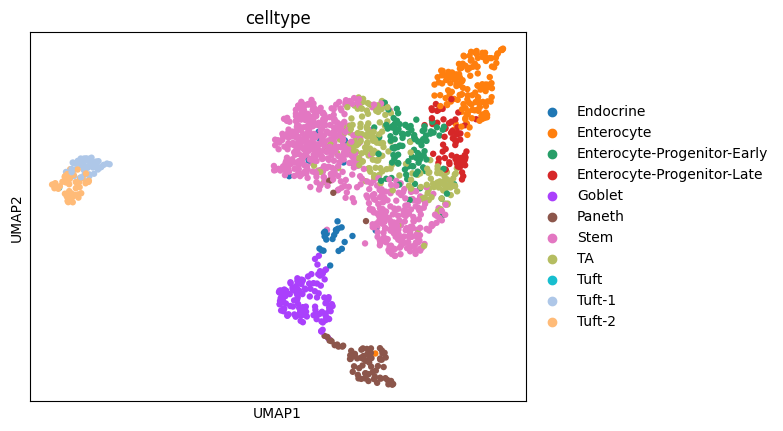

In [9]:
sc.pl.umap(adata, color=['celltype'])

In [10]:
adata_filtered = adata[~adata.obs['celltype'].isin(["Stem", "TA", "Goblet"])]
adata_filtered.obs["celltype"].unique()
    
for i in range(2, 15):
    specCluster2 = SpectralClustering(n_clusters=i)


    sc.pp.neighbors(adata_filtered)
    sc.tl.umap(adata_filtered)  

    adata_filtered.obs['spectral_umap'] = specCluster2.fit_predict(adata_filtered.obsm['X_umap'])  # Use the first 5 principal components
    adata_filtered.obs['spectral_umap'] = adata_filtered.obs['spectral_umap'].astype('category')

    # sc.pl.umap(adata_filtered, color=['celltype', 'spectral_umap'], ncols=1)
    print(f"davies Bouldin index for {i} clusters: {davies_bouldin_score(adata_filtered.obsm['X_umap'], adata_filtered.obs['spectral_umap'])}")

NameError: name 'davies_bouldin_score' is not defined

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print(f"sillhouette score pca: {silhouette_score(adata.obsm['X_pca'][:, :3], adata.obs['spectral_pca'])}")
print(f"sillhouette score umap: {silhouette_score(adata.obsm['X_umap'], adata.obs['spectral_umap'])}")
print(f"sillhouette score tsne: {silhouette_score(adata.obsm['X_tsne'], adata.obs['spectral_tsne'])}")

print(f"davies bouldin score pca: {davies_bouldin_score(adata.obsm['X_pca'][:, :3], adata.obs['spectral_pca'])}")
print(f"davies bouldin score umap: {davies_bouldin_score(adata.obsm['X_umap'], adata.obs['spectral_umap'])}")
print(f"davies bouldin score tsne: {davies_bouldin_score(adata.obsm['X_tsne'], adata.obs['spectral_tsne'])}")

sillhouette score pca: 0.382634699344635
sillhouette score umap: 0.4490610361099243
sillhouette score tsne: 0.41116470098495483
davies bouldin score pca: 0.7408283620067618
davies bouldin score umap: 0.6703146623744001
davies bouldin score tsne: 1.0306340949556534


## Visualisation of the data

Number of cells with celltype Enterocyte:
146
Number of cells with celltype Stem:
599
Number of cells with celltype Goblet:
116
Number of cells with celltype TA:
190
Number of cells with celltype Enterocyte-Progenitor-Late:
66
Number of cells with celltype Endocrine:
29
Number of cells with celltype Enterocyte-Progenitor-Early:
106
Number of cells with celltype Paneth:
75
Number of cells with celltype Tuft-1:
42
Number of cells with celltype Tuft-2:
45
Number of cells with celltype Tuft:
1


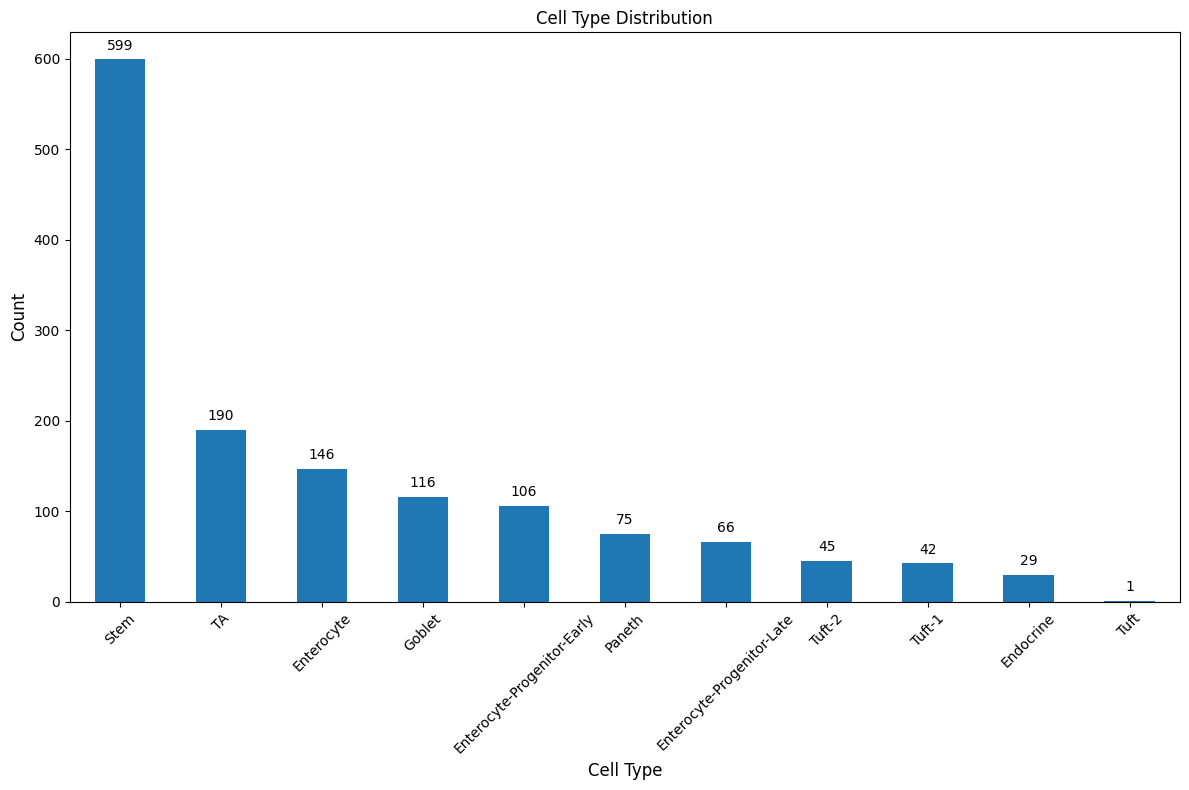

In [ ]:
import seaborn as sns
celltypes = adata.obs["celltype"].unique()  

for celltype in celltypes:  
    # print the number of cells with celltype = celltype in the data
    print(f"Number of cells with celltype {celltype}:")
    print(adata.obs["celltype"].value_counts()[celltype])

celltype_counts = adata.obs['celltype'].value_counts()

celltype_counts_df = celltype_counts.reset_index()
celltype_counts_df.columns = ['celltype', 'count']

# Create the bar plot
plt.figure(figsize=(12, 8))
# adata.obs['celltype'].value_counts().plot(kind='bar', color='skyblue')
ax = celltype_counts.plot(kind='bar')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Customize the plot
plt.title('Cell Type Distribution')
plt.xlabel('Cell Type', size=12)
plt.ylabel('Count', size=12)
plt.xticks(rotation=45, size=10)
plt.tight_layout()

# Show the plot
plt.show()


# Clustering of data

In [ ]:
from sklearn.cluster import SpectralClustering
specCluster = SpectralClustering(n_clusters=10, random_state=41)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

In [ ]:
adata.obsm["X_umap"]

array([[10.827472 , 16.822014 ],
       [ 6.0705214,  7.6666164],
       [11.107562 ,  8.637976 ],
       ...,
       [-5.838171 ,  4.038118 ],
       [-6.0219774,  5.1305933],
       [-5.4262633,  4.0391345]], dtype=float32)

In [ ]:
adata.obs["spectral_umap"] = specCluster.fit_predict(adata.obsm["X_umap"])
adata.obs["spectral_umap"] = adata.obs["spectral_umap"].astype("category")

# adata.obs["spectral_full"] = specCluster.fit_predict(adata.X)
# adata.obs["spectral_full"] = adata.obs["spectral_full"].astype("category")

# adata.obs["spectral_pca"] = specCluster.fit_predict(adata.obsm["X_pca"])
# adata.obs["spectral_pca"] = adata.obs["spectral_pca"].astype("category")

In [ ]:
# calculate silhouette score for each datapoint
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(adata.obsm["X_umap"], adata.obs["spectral_umap"])
adata.obs["silhouette"] = silhouette_vals
avgsil = silhouette_vals.mean()
avgsil

0.4589924

In [ ]:
best_n_clusters = 4
best_silhouette = -1

for i in range(2, 15):
    specCluster = SpectralClustering(n_clusters=i, random_state=41)
    adata.obs["spectral_umap"] = specCluster.fit_predict(adata.obsm["X_umap"])
    adata.obs["spectral_umap"] = adata.obs["spectral_umap"].astype("category")
    silhouette_vals = silhouette_samples(adata.obsm["X_umap"], adata.obs["spectral_umap"])
    adata.obs["silhouette"] = silhouette_vals
    avgsil = silhouette_vals.mean()
    if avgsil > best_silhouette:
        best_n_clusters = i
        best_silhouette = avgsil
    print(f"Average silhouette score for {i} clusters: {avgsil}")
print(f"best number of clusters: {best_n_clusters}")
print(f"best silhouette score: {best_silhouette}")

Average silhouette score for 2 clusters: 0.6629169583320618
Average silhouette score for 3 clusters: 0.5741437077522278
Average silhouette score for 4 clusters: 0.5430169105529785
Average silhouette score for 5 clusters: 0.48441946506500244
Average silhouette score for 6 clusters: 0.5401319265365601
Average silhouette score for 7 clusters: 0.5179165601730347
Average silhouette score for 8 clusters: 0.5040435194969177
Average silhouette score for 9 clusters: 0.477906733751297
Average silhouette score for 10 clusters: 0.4589923918247223
Average silhouette score for 11 clusters: 0.4361039996147156
Average silhouette score for 12 clusters: 0.4245772957801819
Average silhouette score for 13 clusters: 0.40951526165008545
Average silhouette score for 14 clusters: 0.4184395968914032
best number of clusters: 2
best silhouette score: 0.6629169583320618


In [ ]:
# davies bouldin index 
from sklearn.metrics import davies_bouldin_score
best_n_clusters = 4
best_davies = -1

for i in range(4, 20):
    specCluster = SpectralClustering(n_clusters=i, random_state=41)
    adata.obs["spectral_umap"] = specCluster.fit_predict(adata.obsm["X_umap"])
    adata.obs["spectral_umap"] = adata.obs["spectral_umap"].astype("category")
    davies_bouldin = davies_bouldin_score(adata.obsm["X_umap"], adata.obs["spectral_umap"])
    if davies_bouldin > best_davies:
        best_n_clusters = i
        best_davies = davies_bouldin
    print(f"Average Davies score for {i} clusters: {davies_bouldin}")
print(f"best number of clusters: {best_n_clusters}")
print(f"best Davies score: {best_davies}")

Average Davies score for 4 clusters: 0.44176015512969885
Average Davies score for 5 clusters: 0.5157089092104675
Average Davies score for 6 clusters: 0.5474148822567693
Average Davies score for 7 clusters: 0.5845807733545012
Average Davies score for 8 clusters: 0.5762684468797099
Average Davies score for 9 clusters: 0.6123352263447835
Average Davies score for 10 clusters: 0.6409651755246198
Average Davies score for 11 clusters: 0.6938578826443428
Average Davies score for 12 clusters: 0.6983903547331693
Average Davies score for 13 clusters: 0.7467063088050204
Average Davies score for 14 clusters: 0.7011713780807367
Average Davies score for 15 clusters: 0.7205654758997063
Average Davies score for 16 clusters: 0.7682881179471728
Average Davies score for 17 clusters: 0.7482668034599115
Average Davies score for 18 clusters: 0.7618613781864748
Average Davies score for 19 clusters: 0.7674453113177819
best number of clusters: 16
best Davies score: 0.7682881179471728


In [ ]:
# calinski harabasz index   
from sklearn.metrics import calinski_harabasz_score
best_n_clusters = 4
best_calinski = -1

In [ ]:
def createSilhouetteBar(pairs):
    # plot bar hcart of silhouette scores
    plt.figure(figsize=(12, 8))
    plt.bar(pairs.keys(), pairs.values())
    plt.title("Silhouette Scores for Each Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Silhouette Score")
    plt.xticks(range(10))

    # annotate each bar with its value
    for i, score in pairs.items():
        plt.text(i, score, round(score, 2), ha='center', va='bottom')
        
    plt.show()

Silhouette score for cluster 0:
0.36448961
Silhouette score for cluster 1:
0.59663594
Silhouette score for cluster 2:
0.74239147
Silhouette score for cluster 3:
0.28766724
Silhouette score for cluster 4:
0.396331
Silhouette score for cluster 5:
0.54461455
Silhouette score for cluster 6:
0.35696575
Silhouette score for cluster 7:
0.90949667
Silhouette score for cluster 8:
0.40958536
Silhouette score for cluster 9:
0.35060513


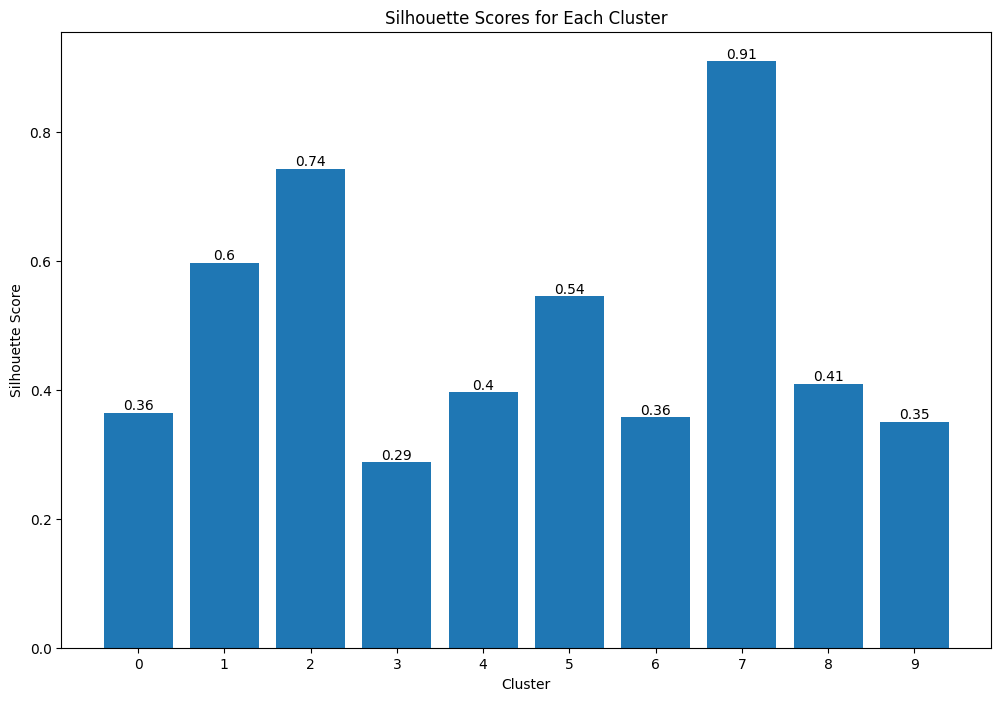

In [ ]:
silhouette_dict = {}

for i in range(10):
    print(f"Silhouette score for cluster {i}:")
    silhouette_dict[i] = silhouette_vals[adata.obs["spectral_umap"] == i].mean()
    print(silhouette_dict[i])

createSilhouetteBar(silhouette_dict)

Number of cells in cluster 0:
celltype
Stem                           85
TA                             72
Endocrine                       3
Enterocyte-Progenitor-Early     2
Name: count, dtype: int64
Number of cells in cluster 1:
celltype
Stem         119
TA             3
Endocrine      1
Paneth         1
Name: count, dtype: int64
Number of cells in cluster 2:
celltype
Endocrine    19
Goblet        1
Stem          1
Name: count, dtype: int64
Number of cells in cluster 3:
celltype
Goblet    59
Name: count, dtype: int64
Number of cells in cluster 4:
celltype
Paneth    10
Goblet     4
Name: count, dtype: int64
Number of cells in cluster 5:
celltype
Enterocyte-Progenitor-Late     36
TA                             33
Enterocyte-Progenitor-Early     4
Stem                            1
Name: count, dtype: int64
Number of cells in cluster 6:
celltype
Enterocyte                     63
Enterocyte-Progenitor-Late     15
Enterocyte-Progenitor-Early     2
Name: count, dtype: int64
Number of cells 

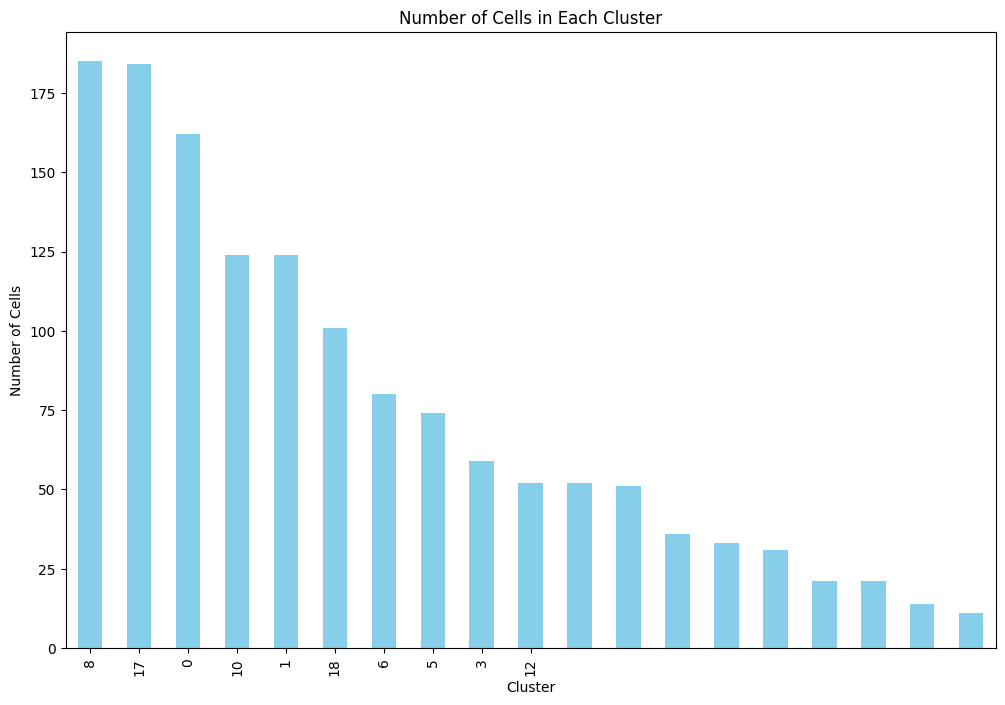

In [ ]:
for i in range(10):
    print(f"Number of cells in cluster {i}:")
    print(adata[adata.obs["spectral_umap"] == i].obs["celltype"].value_counts())

# plot a bar chart of the number of cells in each cluster
plt.figure(figsize=(12, 8))
adata.obs["spectral_umap"].value_counts().plot(kind='bar', color='skyblue')
plt.title("Number of Cells in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Cells")
plt.xticks(range(10))
plt.show()


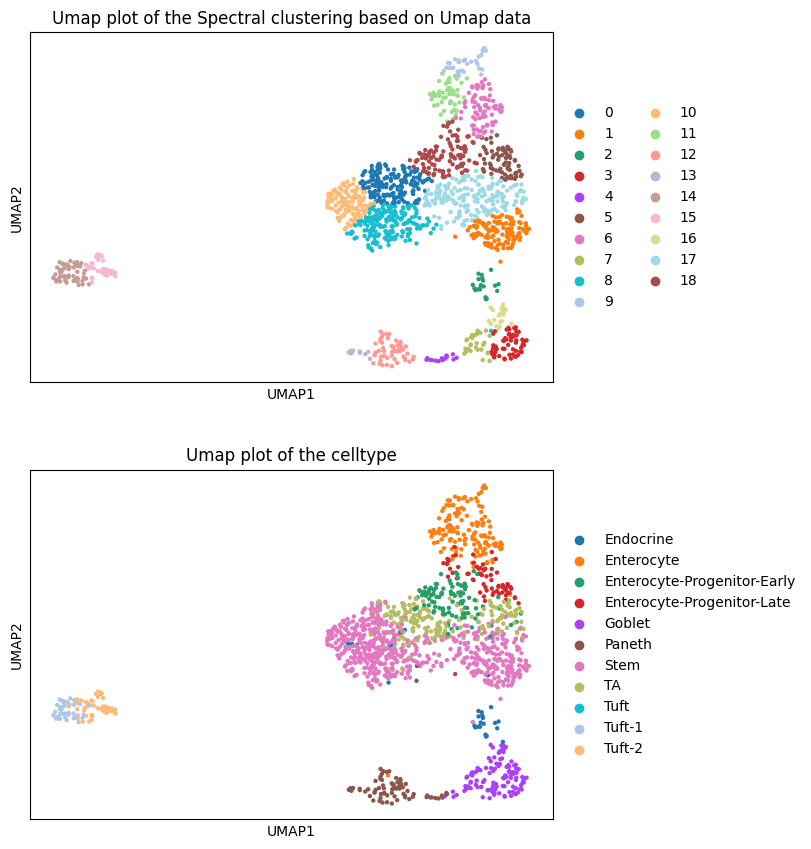

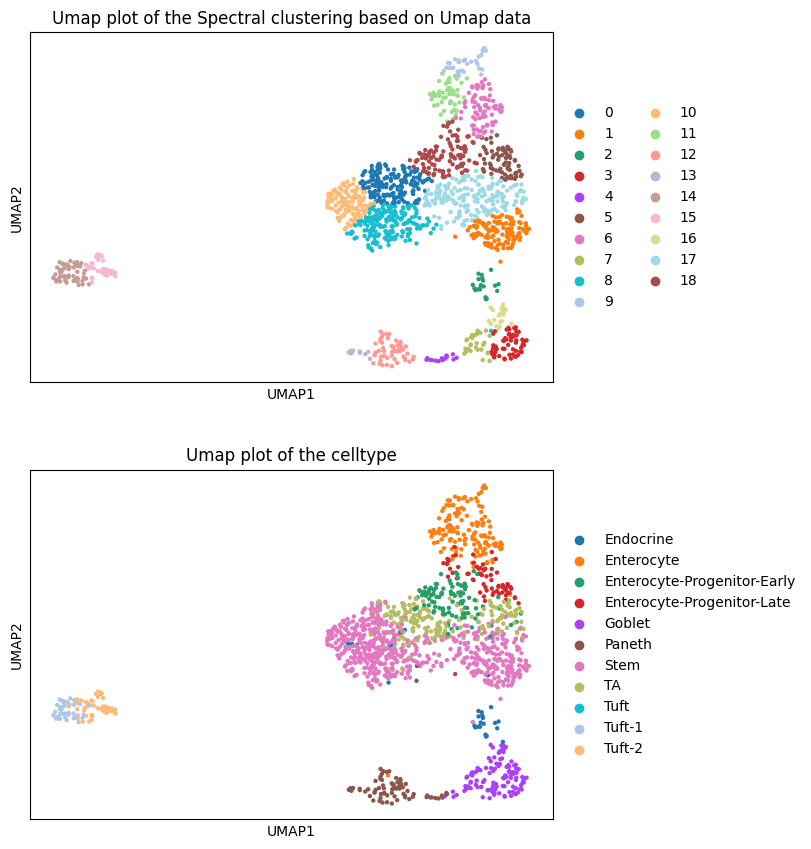

In [ ]:


sc.pl.umap(adata, 
          color=["spectral_umap","celltype"], 
          ncols=1, 
          legend_fontoutline=2, 
          legend_fontsize=10,  
          size=40, 
          palette=sc.pl.palettes.default_20, 
          return_fig=True, 
          title = ["Umap plot of the Spectral clustering based on Umap data", "Umap plot of the celltype"], 
          )  

In [ ]:
# set random numbers to the bad_cluster column
adata.obs["bad_cluster"] = np.random.randint(0, 15, adata.shape[0])
# adata.obs["bad_cluster"] = np.random.randint(0, 15, adata.shape[0])
adata.obs["bad_cluster"].to_csv("bad_cluster.csv")

In [ ]:
metrics.davies_bouldin_score(adata.X, adata.obs["bad_cluster"])

14.858433113448388

In [ ]:
from pre_processing import *

In [ ]:
import sklearn.metrics as metrics
metrics.calinski_harabasz_score(adata.X, adata.obs["spectral_umap"])   
print(metrics.davies_bouldin_score(adata.obsm["X_umap"], adata.obs["spectral_umap"]))
print(metrics.davies_bouldin_score(adata.obsm["X_umap"], adata.obs["spectral_umap"]))

NameError: name 'adata' is not defined

In [ ]:
sc.pl.pca(adata, 
          color=["spectral","celltype"], 
          ncols=1, 
          legend_fontoutline=2, 
          legend_fontsize=10,  
          size=40, 
          palette=sc.pl.palettes.default_20, 
          return_fig=True, 
          title = ['PCA plot of dimensionally reduced data with pca with K-means Clustering', "PCA of scRNA-seq Data with Cell Type Annotations"], 
          annotate_var_explained=True
          )  

In [ ]:
cell_cycle_genes = [
    "Ccna1", "Ccna2", "Ccnb1", "Ccnb2", "Ccnd1", "Ccnd2", "Ccnd3", "Ccne1", "Ccne2",
    "Cdk1", "Cdk2", "Cdk4", "Cdk6", "Cdkn2a", "Cdkn2b", "Cdkn2c", "Cdkn2d", "Cdkn1a",
    "Cdkn1b", "Cdkn1c", "Rb1", "E2f1", "Cdc25a", "Cdc25b", "Cdc25c", "Wee1", "Chek1",
    "Chek2", "Tp53", "Atm", "Atr", "Brca1", "Brca2", "Mad1l1", "Mad2l1", "Bub1",
    "Bub1b", "Aurka", "Aurkb", "Plk1", "Cep152", "Stil", "Orc1", "Orc2", "Orc3",
    "Orc4", "Orc5", "Orc6", "Mcm2", "Mcm3", "Mcm4", "Mcm5", "Mcm6", "Mcm7",
    "Cdt1", "Cdc6", "Gmnn", "Anapc1", "Anapc2", "Cdc27", "Anapc4", "Cdc20", "Fzr1"
]
adata.var_names = adata.var_names.str.capitalize()
# filter all vars that are not in cell_cycle_genes
adata_without_cycles = adata[:, ~adata.var_names.isin(cell_cycle_genes)]
# adata_without_cycles = adata[adata

adata_without_cycles.var


,n_cells,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,mean,std
0610009b14rik,36,38,1.188965,97.478434,1791.77,True,1448.0,1.217491,9.844739e+01,2.068644,6.977379e-15,0.328692
0610009l18rik,224,236,8.867094,84.339748,13362.71,True,1945.0,8.740537,7.352229e+02,1.848213,-2.715830e-13,0.780000
0610012h03rik,5,5,0.219900,99.668215,331.39,True,1287.0,0.234198,2.194874e+01,2.148372,5.283877e-15,0.119230
0610040b10rik,66,68,2.111672,95.487724,3182.29,True,1077.0,2.221456,2.001813e+02,2.300121,6.227041e-14,0.414160
1110006o24rik,80,86,2.532442,94.293298,3816.39,True,928.0,2.536530,3.432611e+02,2.434020,1.099289e-13,0.413413
...,...,...,...,...,...,...,...,...,...,...,...,...
Zg16,178,189,2401.762767,87.458527,3619456.49,True,25.0,2489.655717,4.024231e+08,23.631436,1.483864e-12,1.405252
Zkscan4,59,62,1.289529,95.885866,1943.32,True,1321.0,1.265329,1.056039e+02,2.132747,4.738542e-14,0.308520
Zmat1,52,53,0.645395,96.483079,972.61,True,1926.0,0.686120,4.639451e+01,1.854773,-1.311742e-14,0.204813
Zpbp2,14,15,0.302754,99.004645,456.25,True,1178.0,0.314728,2.338315e+01,2.227057,1.188496e-14,0.144922


In [ ]:
from sklearn.cluster import SpectralClustering
specCluster = SpectralClustering(n_clusters=2, random_state=41)
adata_without_cycles.obs["SpectralClustering"] = specCluster.fit_predict(adata_without_cycles.X)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:427: UserWarning: Exited at iteration 22 with accuracies 
[6.13582692e-06 1.87201732e-05 6.35281971e-04]
not reaching the requested tolerance 2.1085143089294434e-05.
Use iteration 22 instead with accuracy 
0.00022004599035628544.

  _, diffusion_map = lobpcg(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:427: UserWarning: Exited postprocessing with accuracies 
[6.13582692e-06 1.87201732e-05 6.35281971e-04]
not reaching the requested tolerance 2.1085143089294434e-05.
  _, diffusion_map = lobpcg(
/var/folders/97/_bppr_xn34v9xtss08ljc1840000gn/T/ipykernel_42804/1085259600.

In [ ]:
cells_to_omit = ["Tuft", "Tuft-1", "Tuft-2"]
adata_without_tufts = adata_without_cycles[~adata_without_cycles.obs["celltype"].isin(cells_to_omit)]


In [ ]:
adata_without_tufts.obs["celltype"].unique()

['Enterocyte', 'Stem', 'Goblet', 'TA', 'Enterocyte-Progenitor-Late', 'Endocrine', 'Enterocyte-Progenitor-Early', 'Paneth']
Categories (8, object): ['Endocrine', 'Enterocyte', 'Enterocyte-Progenitor-Early', 'Enterocyte-Progenitor-Late', 'Goblet', 'Paneth', 'Stem', 'TA']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scanpy/plotting/_utils.py:465: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


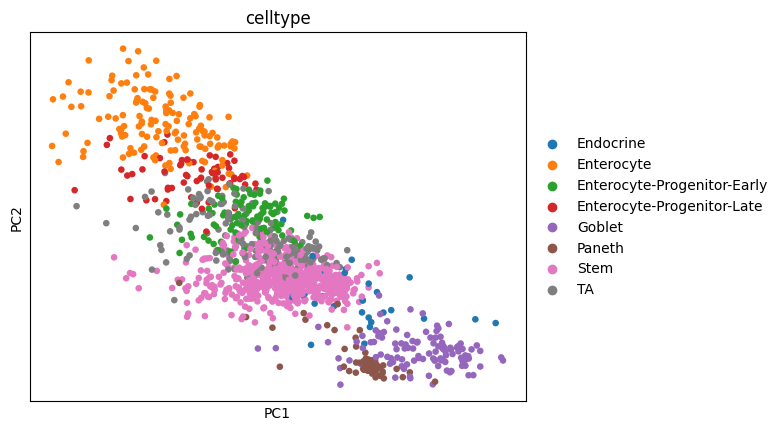

In [ ]:
sc.pl.pca(adata_without_tufts, color="celltype")

In [ ]:
sc.pl.umap(adata_without_tufts, color="celltype")


KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

In [ ]:
cells_to_keep = ["TA"]
adata_tas_only = adata_without_tufts[adata_without_tufts.obs["celltype"].isin(cells_to_keep)]

In [ ]:
adata_tas_only.obs["spectral_clustering"] = specCluster.fit_predict(adata_tas_only.X)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/pairwise.py:383: RuntimeWarning: invalid value encountered in add
  distances += XX
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:704: RuntimeWarning: overflow encountered in square
  lloyd_iter(
/Library/Frameworks/Python.framework/Versions/3.11/lib/pyt

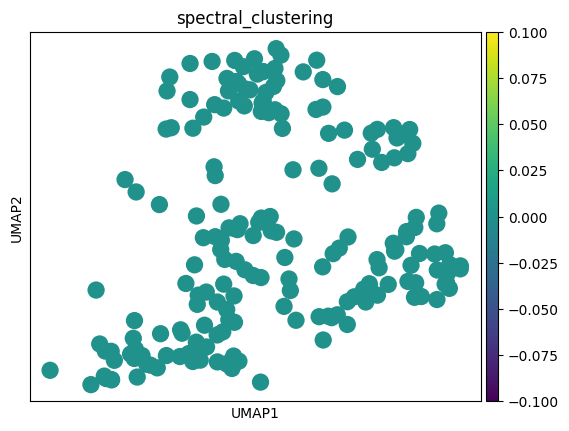

In [ ]:
sc.pl.umap(adata_tas_only, color="spectral_clustering")

In [ ]:
# dataset of TA cells with cell_cycle genes included
adata_tas_cycles = adata[adata.obs["celltype"].isin(["TA"])] 
sc.pp.neighbors(adata_tas_cycles)
sc.tl.umap(adata_tas_cycles)

In [ ]:
adata_tas_cycles.obs["spectral_2"] = specCluster.fit_predict(adata_tas_cycles.obsm["X_umap"])
adata_tas_cycles.obs["spectral_2"] = adata_tas_cycles.obs["spectral_2"].astype("category")

NameError: name 'specCluster' is not defined

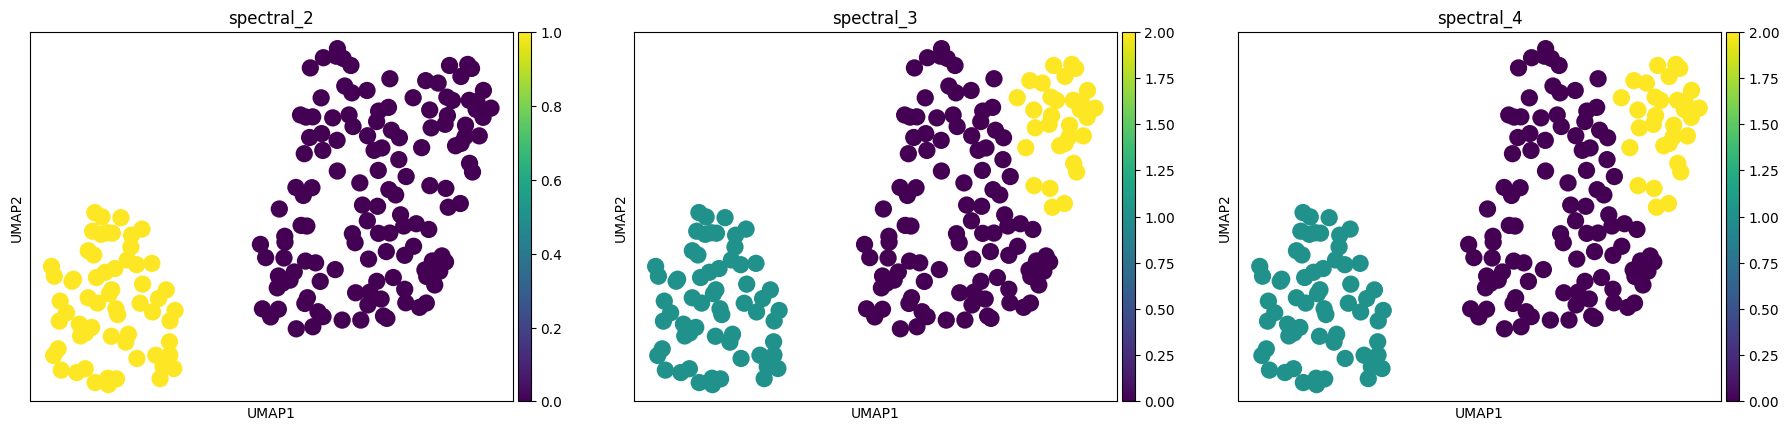

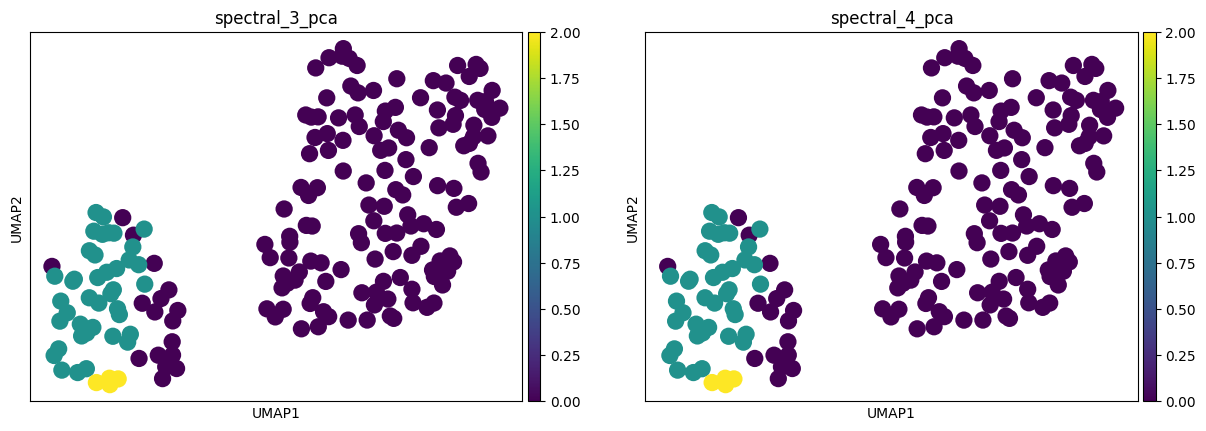

In [ ]:
specCluster_3 = SpectralClustering(n_clusters=3, random_state=41)
specCluster_4 = SpectralClustering(n_clusters=3, random_state=41)

adata_tas_cycles.obs["spectral_3"] = specCluster_3.fit_predict(adata_tas_cycles.obsm["X_umap"])
adata_tas_cycles.obs["spectral_4"] = specCluster_4.fit_predict(adata_tas_cycles.obsm["X_umap"])
adata_tas_cycles.obs["spectral_3"] = adata_tas_cycles.obs["spectral_3"].astype("category")
adata_tas_cycles.obs["spectral_4"] = adata_tas_cycles.obs["spectral_4"].astype("category")


sc.pl.umap(adata_tas_cycles, color=["spectral_2", "spectral_3", "spectral_4"])

adata_tas_cycles.obs["spectral_3_pca"] = specCluster_3.fit_predict(adata_tas_cycles.obsm["X_pca"])
adata_tas_cycles.obs["spectral_4_pca"] = specCluster_4.fit_predict(adata_tas_cycles.obsm["X_pca"])
adata_tas_cycles.obs["spectral_3_pca"] = adata_tas_cycles.obs["spectral_3_pca"].astype("category")
adata_tas_cycles.obs["spectral_4_pca"] = adata_tas_cycles.obs["spectral_4_pca"].astype("category")
sc.pl.umap(adata_tas_cycles, color=["spectral_3_pca", "spectral_4_pca"])



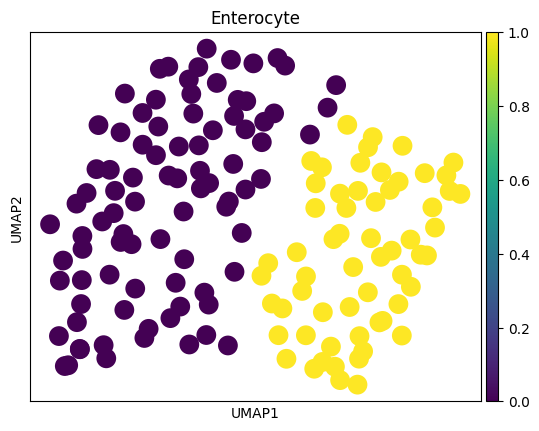

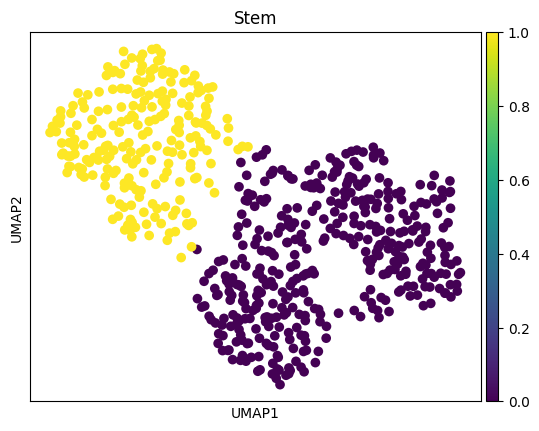

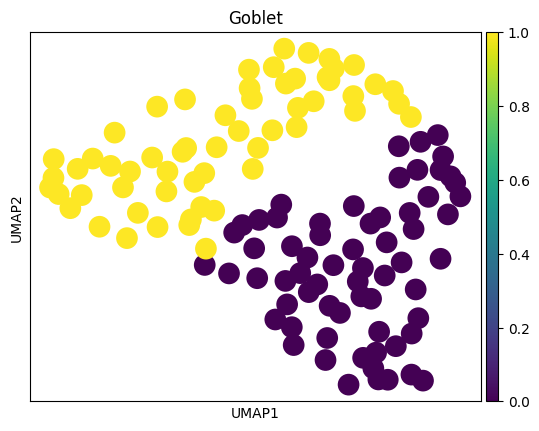

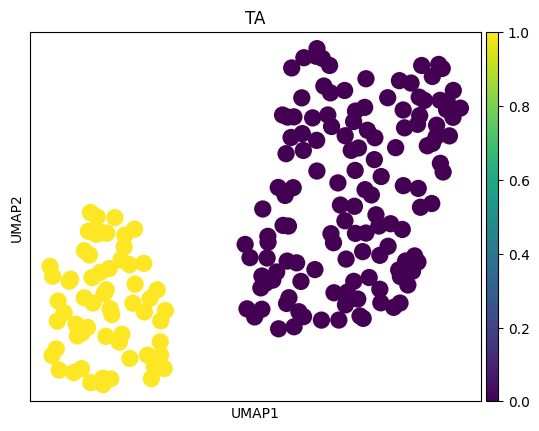

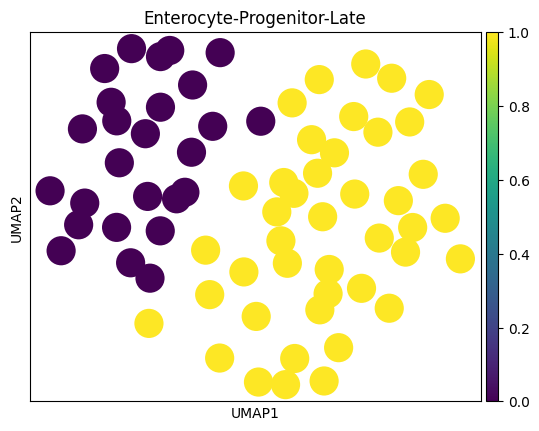

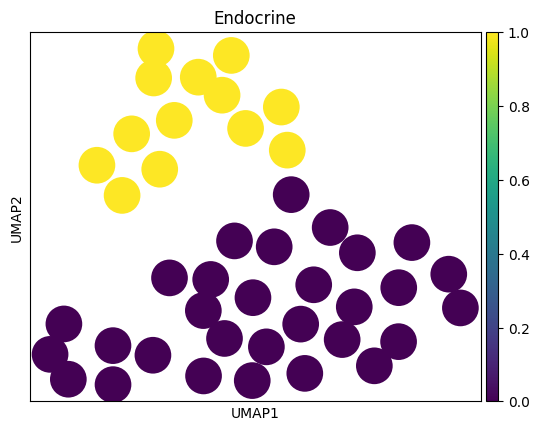

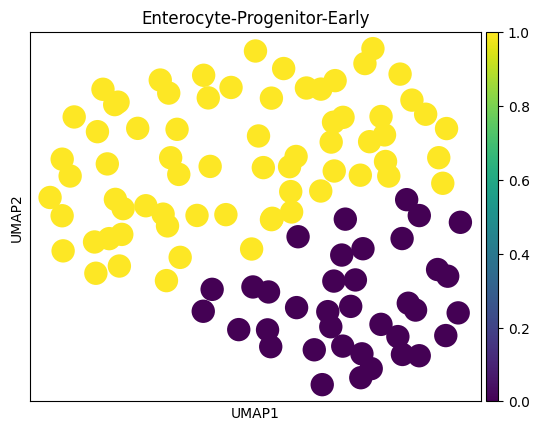

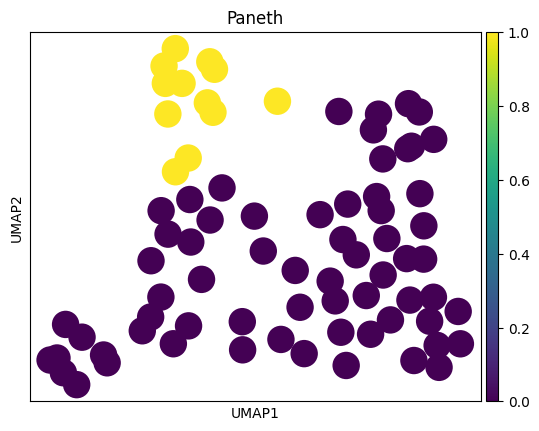

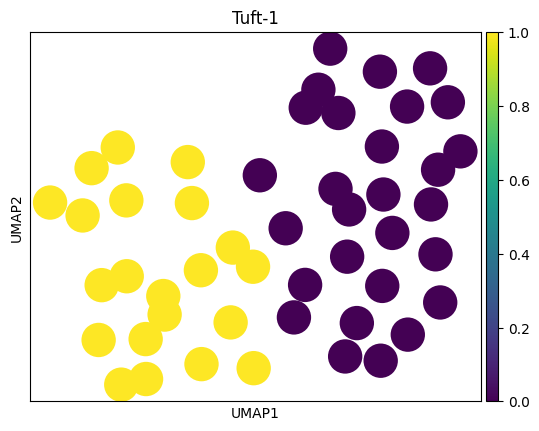

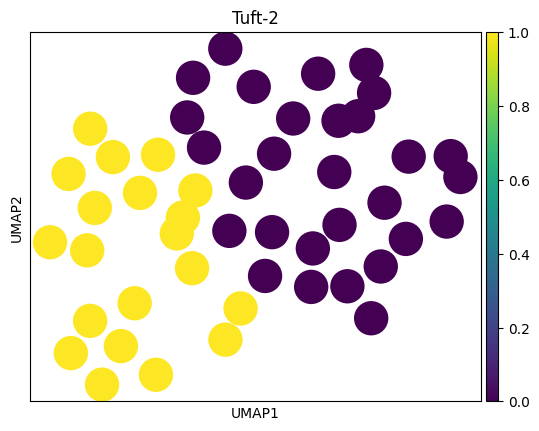

celltype: Tuft has to few cells to cluster on


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/umap/spectral.py:521: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(


In [ ]:
celltypes = adata.obs["celltype"].unique() 
for celltype in celltypes:
    try: 
        adata_celltype = adata_without_cycles[adata_without_cycles.obs["celltype"] == celltype]
        sc.pp.neighbors(adata_celltype)
        sc.tl.umap(adata_celltype)
        adata_celltype.obs["spectral_clustering"] = specCluster.fit_predict(adata_celltype.obsm["X_umap"])
        sc.pl.umap(adata_celltype, color="spectral_clustering", title=celltype)
    except:
        print(f"celltype: {celltype} has to few cells to cluster on")

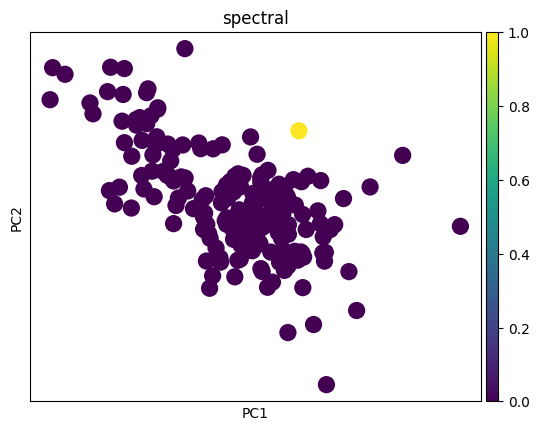

In [ ]:
adata_tas_cycles.obs["spectral"] = specCluster.fit_predict(adata_tas_cycles.obsm["X_pca"])
sc.pl.pca(adata_tas_cycles, color="spectral")

In [ ]:
adata_tas_cycles

AnnData object with n_obs × n_vars = 194 × 17520
    obs: 'celltype', 'n_genes_by_counts', 'total_counts', 'spectral'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'umap', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
adata_tas_cycles.obs["celltype"].unique()

['TA']
Categories (1, object): ['TA']

In [ ]:
adata.var_names

Index(['0610005c13rik', '0610007n19rik', '0610007p14rik', '0610008f07rik',
       '0610009b14rik', '0610009b22rik', '0610009d07rik', '0610009l18rik',
       '0610009o20rik', '0610010b08rik',
       ...
       'Zwint', 'Zxda', 'Zxdb', 'Zxdc', 'Zyg11a', 'Zyg11b', 'Zyx', 'Zzef1',
       'Zzz3', 'L7rn6'],
      dtype='object', length=17520)

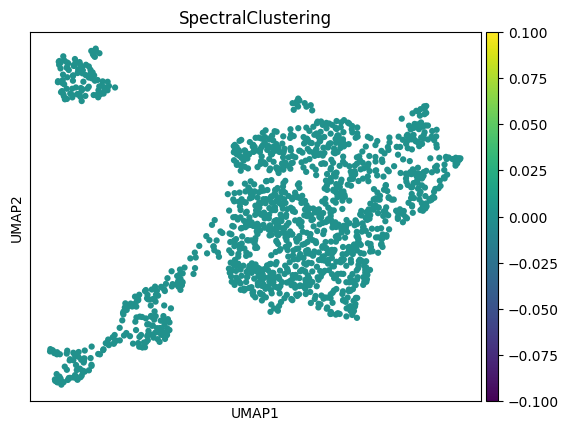

In [ ]:
sc.pl.umap(adata_without_cycles, color=["SpectralClustering"], legend_loc="on data")